In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', palette='deep')

In [2]:
df = pd.read_csv('cleaned_dataset.csv')
df = df.drop(labels = ["Id"],axis = 1)
df = df.drop(labels = ["ActivityDate"],axis = 1)
# we drop activity date because it was not possible to normalize this feature 
# this does seem to be an important feature, so need to find a way to incorporate this feature into the model

In [3]:
train, test = train_test_split(df, test_size=0.2)
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## Transformation

In [4]:
for feature in dataset.columns:
    dataset[feature] = np.log1p(dataset[feature])

In [5]:
Y = dataset["Calories"]
df = dataset.drop(labels="Calories",axis = 1)
X_train = dataset[:train_len]
test = dataset[train_len:]
Y_train = Y[:train_len]

## Normalization

In [6]:
N = RobustScaler()

N.fit(df)

df = N.transform(df)

## Modelling

In [7]:
lassocv = LassoCV(eps=1e-7) 
ridge = Ridge(alpha=1e-6) 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)
# need to check if how different eps values has an effect on the performance of the models

In [8]:
def RMSE(estimator,X_train, Y_train, cv=5,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [9]:
RMSE(lassocv, X_train, Y_train)

0.00034224096470938833

In [10]:
RMSE(ridge, X_train, Y_train)

4.347332845550877e-09

In [11]:
RMSE(lassolarscv, X_train, Y_train)

5.104335848691937e-16

In [12]:
RMSE(elasticnetcv, X_train, Y_train)

0.00034313794864722873

In [13]:
# most of these RMSE are very low. possible overfitting?

In [14]:
lassocv.fit(X_train,Y_train)
ridge.fit(X_train,Y_train)
lassolarscv.fit(X_train,Y_train)
elasticnetcv.fit(X_train,Y_train)

ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=1e-15, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [15]:
Y_pred_lassocv = (lassocv.predict(test))
Y_pred_lassolarscv = (lassolarscv.predict(test))
Y_pred_elasticnetcv = (elasticnetcv.predict(test))

In [16]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)
RMSE(model_xgb,X_train,Y_train)

0.136531895204811

In [17]:
# this has reduced from over 100 to less than 0.5 after log transformation!! yay :)

In [18]:
model_xgb.fit(X_train,Y_train)
Y_pred_xgb = (model_xgb.predict(test))

[00:22:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [19]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
RMSE(GBoost,X_train,Y_train)

0.2961088948564625

In [20]:
# this reduced from over 200 to less than 0.5 after log transformation!

In [21]:
GBoost.fit(X_train,Y_train)
Y_pred_GBoost = (GBoost.predict(test))

<Figure size 432x288 with 0 Axes>

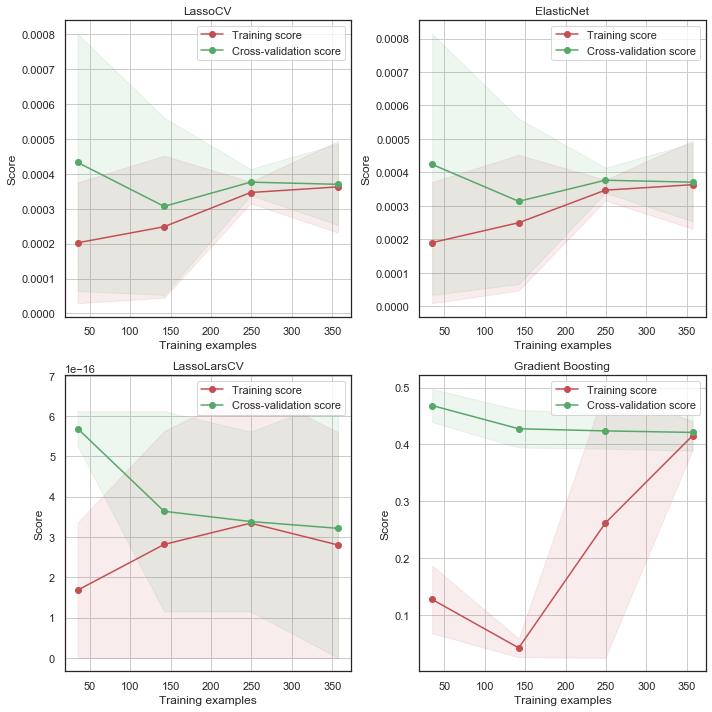

<Figure size 432x288 with 0 Axes>

In [22]:
def plot_learning_curves(estimators, titles, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 4)):
    """Generate a simple plot of the test and training learning curve"""
    nrows = len(estimators)//2
    ncols = (len(estimators)//nrows)+ (0 if len(estimators) % nrows == 0 else 1)
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    
    n = 0
    for col in range(ncols):
        for row in range(nrows):
            estimator = estimators[n]
            title = titles[n]
            axes[row,col].set_title(title)
            
            if ylim is not None:
                axes[row,col].set_ylim(*ylim)
            
            axes[row,col].set_xlabel("Training examples")
            axes[row,col].set_ylabel("Score")
            
            train_sizes, train_scores, test_scores = learning_curve(estimator,
                    X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
                    scoring="neg_mean_squared_error")
    
            train_scores = np.sqrt(-train_scores)
            test_scores = np.sqrt(-test_scores)
    
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)
            axes[row,col].grid()
        
            axes[row,col].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
            axes[row,col].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
            axes[row,col].plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
            axes[row,col].plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
            axes[row,col].legend(loc="best")
            
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

    

estimators = [lassocv,lassolarscv,elasticnetcv,GBoost]
titles = ["LassoCV","LassoLarsCV","ElasticNet","Gradient Boosting",]

plot_learning_curves(estimators, titles, X_train, Y_train, cv=2 ,n_jobs=4)

Sources: https://www.kaggle.com/yassineghouzam/eda-introduction-to-ensemble-regression